In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import nibabel as nib
import pydicom as dicomio 
import torch
import torch.optim as optim
import time

# 让 matplotlib 图表直接在 Jupyter 中显示
%matplotlib inline 

# 导入本地模块
try:
    from loss import TverskyLoss, MixedLoss
    from net import UNet_2D, UNet_3D
    from volume_patch_composer import volume_composer, patch_creator
    from dataset import Pancreas_2D_dataset, Pancreas_3D_dataset, partitioning
    from metrics import performance_metrics
    from train import train_2D, train_3D
    from inference import get_inference_performance_metrics_3D
except ImportError as e:
    print(f"❌ 错误: 缺少必要的模块文件 (如 net.py, loss.py)。\n详细信息: {e}")

print("库导入完成。")

库导入完成。


In [2]:
# ================= ⚙️ 配置区域 =================
CONFIG = {
    'raw_ct_dir': './Pancreas-CT',              
    'raw_label_dir': './Pancreas-CT-Label',     
    'processed_2d_dir': './data',               
    'processed_3d_dir': './data3D',             
    
    'unet_2d': False,              
    'batch_size': 32,                
    'num_workers': 20,               
    'n_epochs': 50,                
    'inference_only': False,       
    'train_on_gpu': torch.cuda.is_available(),
    'seed': 51
}

# ================= 🛠️ 工具函数 =================
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

def process_ct_window(ct_array, w_level=40, w_width=400):
    min_val = w_level - w_width / 2
    max_val = w_level + w_width / 2
    ct_clipped = np.clip(ct_array, min_val, max_val)
    ct_norm = (ct_clipped - min_val) / (max_val - min_val)
    ct_norm = ct_norm * 255.0
    return ct_norm.astype(np.uint8)

def prepare_directories():
    for p in [CONFIG['processed_2d_dir'], CONFIG['processed_3d_dir']]:
        if not os.path.exists(p):
            os.makedirs(p)

# 设置随机种子
set_seed(CONFIG['seed'])
print("配置已加载。")

配置已加载。


In [3]:
def preprocess_data_robust():
    """鲁棒的数据预处理函数"""
    print("--- 检查数据状态 ---")
    check_patient = os.path.join(CONFIG['processed_2d_dir'], 'Patient0082', 'CT')
    if os.path.exists(check_patient) and len(os.listdir(check_patient)) > 0:
        print("✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。")
        return

    print("🔄 未找到完整数据，开始执行预处理 (这可能需要几分钟)...")
    prepare_directories()

    # 检查 pydicom 版本兼容性
    try:
        if not hasattr(dicomio, 'dcmread'):
            dicomio.dcmread = dicomio.read_file
    except:
        pass

    for i in range(1, 83):
        patient_id = '{:04d}'.format(i)
        
        # 路径准备
        nifti_filename = f"label{patient_id}.nii.gz"
        nifti_path = os.path.join(CONFIG['raw_label_dir'], nifti_filename)
        ct_folder_pattern = os.path.join(CONFIG['raw_ct_dir'], f"PANCREAS_{patient_id}", "**", "*.dcm")
        
        # 1. 检查源文件
        if not os.path.exists(nifti_path):
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到标签文件")
            continue
        
        dcm_files = glob.glob(ct_folder_pattern, recursive=True)
        if not dcm_files:
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到 DICOM 文件")
            continue

        # 2. 读取并排序 DICOM
        try:
            slices = []
            for f in dcm_files:
                try:
                    ds = dicomio.dcmread(f)

                    # 先转为 float 避免计算溢出
                    image = ds.pixel_array.astype(np.float32)
                    
                    # 应用斜率和截距 (如果存在)
                    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
                        slope = float(ds.RescaleSlope)
                        intercept = float(ds.RescaleIntercept)
                        image = image * slope + intercept

                    # slices.append(ds)
                    slices.append((float(ds.ImagePositionPatient[2]), image))
                except Exception:
                    pass
            
            if not slices:
                continue

            # 按 Z 轴位置排序
            # slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            slices.sort(key=lambda x: x[0])
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 处理崩溃: {e}")
            continue

        # 3. 读取 Mask
        try:
            mask_obj = nib.load(nifti_path)
            mask_data = mask_obj.get_fdata()
        except Exception as e:
            print(f"❌ [Patient {patient_id}] NIfTI 读取失败: {e}")
            continue

        # 4. 对齐层数
        num_dcm = len(slices)
        num_mask = mask_data.shape[2]
        valid_slices = min(num_dcm, num_mask)
        
        if valid_slices < 10:
            continue
            
        # 5. 保存 PNG
        save_dir_ct = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'CT')
        save_dir_mask = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'Masks')
        os.makedirs(save_dir_ct, exist_ok=True)
        os.makedirs(save_dir_mask, exist_ok=True)

        # ... (前面的代码保持不变)
        try:
            for s in range(valid_slices):
                mask_slice = mask_data[:, :, s]
                
                # 获取原始 CT 数据
                # raw_ct_slice = slices[s].pixel_array.transpose(1, 0)
                raw_ct_slice = slices[s][1].transpose(1, 0)
                
                # --- 🔥 修改开始 🔥 ---
                # 1. 对 CT 进行窗位调整和归一化 (关键修复!)
                processed_ct_slice = process_ct_window(raw_ct_slice, w_level=40, w_width=400)
                
                # 2. 确保 Mask 也是 uint8 格式 (0 和 255, 或者 0 和 1)
                # 建议将 Mask 乘以 255 以便肉眼观察，但在读取时要除回来
                mask_slice = (mask_slice * 255).astype(np.uint8)
                # 这里为了兼容你现有的 dataset 代码(假设它读取0/1)，我们保持 0/1 但转为 uint8
                # mask_slice = mask_slice.astype(np.uint8)
                # --- 🔥 修改结束 🔥 ---

                filename = f"{s:04d}.png"
                cv2.imwrite(os.path.join(save_dir_mask, filename), mask_slice)
                cv2.imwrite(os.path.join(save_dir_ct, filename), processed_ct_slice)
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 保存出错: {e}")      

    print("--- 数据预处理完成 ---")

In [4]:
# 1. 执行预处理
preprocess_data_robust()

# 2. 构建数据索引
print("构建文件索引...")
patient_path_list = {'CT': {}, 'Masks': {}}
patient_image_cnt_CT = {}
patient_image_cnt_Mask = {}
valid_patients = []
patient_dirs = sorted(glob.glob(os.path.join(CONFIG['processed_2d_dir'], 'Patient*')))

for p_dir in patient_dirs:
    p_key = os.path.basename(p_dir)
    ct_files = sorted(glob.glob(os.path.join(p_dir, 'CT', '*.png')))
    mask_files = sorted(glob.glob(os.path.join(p_dir, 'Masks', '*.png')))
    if len(ct_files) > 0 and len(ct_files) == len(mask_files):
        patient_path_list['CT'][p_key] = ct_files
        patient_path_list['Masks'][p_key] = mask_files
        patient_image_cnt_CT[p_key] = len(ct_files)
        patient_image_cnt_Mask[p_key] = len(mask_files)
        valid_patients.append(p_key)

print(f"有效病例数: {len(valid_patients)}")

# 3. 3D 数据缓存
print("检查 3D 数据缓存...")
d1 = torch.linspace(-1, 1, 256)
d2 = torch.linspace(-1, 1, 256)
d3 = torch.linspace(-1, 1, 128)
meshx, meshy, meshz = torch.meshgrid((d1, d2, d3), indexing='ij')
grid = torch.stack((meshx, meshy, meshz), 3).unsqueeze(0)

new_pt_count = 0
for patient in valid_patients:
    out_ct_path = os.path.join(CONFIG['processed_3d_dir'], patient + '_CT.pt')
    if not os.path.exists(out_ct_path):
        try:
            volume_composer(patient, patient_image_cnt_CT, patient_path_list, grid)
            new_pt_count += 1
        except Exception as e:
            print(f"Resizing {patient} error: {e}")

if new_pt_count == 0:
    print("✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。")
else:
    print(f"🔄 新生成了 {new_pt_count} 个 3D 数据文件。")

--- 检查数据状态 ---
✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。
构建文件索引...
有效病例数: 80
检查 3D 数据缓存...
✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。


In [5]:
# 4. 训练准备
print("准备 Dataset...")
part = partitioning(valid_patients, split_ratio=[0.7, 0.1, 0.2])

# 增加patch大小，可能需要调整学习率、数据增强尺寸、模型初始特征图数量
# kc, kh, kw = 32, 64, 64
# dc, dh, dw = 32, 64, 64
kc, kh, kw = 48, 96, 96  
dc, dh, dw = 48, 96, 96
# kc, kh, kw = 64, 128, 128  
# dc, dh, dw = 64, 128, 128


CT_patches = {}
mask_patches = {}

print("加载 Patches (这步需要一点内存)...")
for p in ['train', 'valid']:
    CT_patches[p], mask_patches[p] = patch_creator(part[p], kw, kh, kc, dw, dh, dc)

dataset_train = Pancreas_3D_dataset(CT_patches['train'], mask_patches['train'], augment=True, is_train=True)
dataset_valid = Pancreas_3D_dataset(CT_patches['valid'], mask_patches['valid'], augment=False, is_train=False)

loaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=CONFIG['batch_size'], 
                                         shuffle=True, num_workers=CONFIG['num_workers'],pin_memory=True),# 启用内存锁定，加速数据传输
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=CONFIG['batch_size'], 
                                         shuffle=False, num_workers=CONFIG['num_workers'],pin_memory=True)
}
print("DataLoader 准备就绪。")

准备 Dataset...
train:  56   valid:  7   test:  17   total:  80
加载 Patches (这步需要一点内存)...
Filtering patches... Original size: 448
Filtered size: 142
DataLoader 准备就绪。


In [6]:
# 5. 初始化模型与优化器
print("初始化模型...")
model = UNet_3D(1, 1, 32, 0.3)
if CONFIG['train_on_gpu']:
    model.cuda()        

# ================= 关键修改：加载预训练模型 =================
# ⚠️ 注意：请确认文件名是否正确
checkpoint_path = 'results/run_20251130-0056_model.pt' 

if os.path.exists(checkpoint_path):
    print(f"🔄 正在加载预训练模型: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ 加载成功！将在现有基础上继续训练。")
else:
    print("⚠️ 未找到预训练模型，将从头开始训练。")     
# ========================================================

# ✅ 使用新的混合 Loss
# alpha=0.7 强调召回，bce_weight=0.5 提供梯度平滑
# criterion = MixedLoss(alpha=0.5, beta=0.5, bce_weight=0.2)

# pos_weight 可以用来处理样本不平衡，例如胰腺像素很少，可以设大一点（如 10.0）
# 如果不需要加权，直接用 nn.BCEWithLogitsLoss() 即可
criterion = torch.nn.BCEWithLogitsLoss()

# 定义 Loss (这里用了你新的参数)
# criterion = TverskyLoss(1e-6, 0.7, 0.3)
# 1. 定义基础优化器 (LR 会被 Scheduler 覆盖，所以这里初始 LR 可以随意，但建议设为 max_lr 的 1/10 或 1/25)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)  # 在优化器中增加权重衰减

# 2.定义 OneCycleLR
# max_lr: 最大学习率，可以尝试 1e-3 或 5e-4
# steps_per_epoch: 每个 epoch 的 batch 数量
# epochs: 总 epoch 数
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, 
#     max_lr=5e-4, 
#     steps_per_epoch=len(loaders['train']), 
#     epochs=CONFIG['n_epochs']
# )

# 余弦退火热身重启
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, 
#     T_0=20,           # 初始周期长度
#     T_mult=2,         # 周期倍增因子
#     eta_min=1e-6
# )

#当指标进入平原期（不再变化）时，降低学习率。
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # 监控指标是越小越好 (Loss)
    factor=0.5,      # 每次降低一半 (0.1 也可以)
    patience=10,     # 容忍 10 个 Epoch 不下降
)

print("模型初始化完成。")

初始化模型...
🔄 正在加载预训练模型: results/run_20251130-0056_model.pt
✅ 加载成功！将在现有基础上继续训练。
模型初始化完成。


🚀 开始训练: run_20251130-0219


  0%|          | 0/51 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


  2%|▏         | 1/51 [00:59<49:49, 59.79s/it]

Epoch: 1 	Training Loss: 0.6469 	Validation Loss: 0.5683
Specificity: 0.996411 	Sensitivity: 0.534761 	F2_score: 0.494803 	DSC: 0.445431
Validation DSC increased.  Saving model ...
=== Epoch #2 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


  4%|▍         | 2/51 [01:07<23:49, 29.17s/it]

Epoch: 2 	Training Loss: 0.6320 	Validation Loss: 0.5683
Specificity: 0.996708 	Sensitivity: 0.513751 	F2_score: 0.483676 	DSC: 0.445115
=== Epoch #3 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


  6%|▌         | 3/51 [01:15<15:27, 19.32s/it]

Epoch: 3 	Training Loss: 0.6692 	Validation Loss: 0.5705
Specificity: 0.996723 	Sensitivity: 0.509569 	F2_score: 0.480386 	DSC: 0.442945
=== Epoch #4 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


  8%|▊         | 4/51 [01:22<11:29, 14.68s/it]

Epoch: 4 	Training Loss: 0.6279 	Validation Loss: 0.5722
Specificity: 0.996977 	Sensitivity: 0.489308 	F2_score: 0.468509 	DSC: 0.440934
=== Epoch #5 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 10%|▉         | 5/51 [01:29<09:11, 11.99s/it]

Epoch: 5 	Training Loss: 0.6438 	Validation Loss: 0.5738
Specificity: 0.997135 	Sensitivity: 0.476434 	F2_score: 0.460715 	DSC: 0.439450
=== Epoch #6 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 12%|█▏        | 6/51 [01:37<07:52, 10.50s/it]

Epoch: 6 	Training Loss: 0.6565 	Validation Loss: 0.5734
Specificity: 0.997068 	Sensitivity: 0.481135 	F2_score: 0.463365 	DSC: 0.439524
=== Epoch #7 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 14%|█▎        | 7/51 [01:45<07:00,  9.55s/it]

Epoch: 7 	Training Loss: 0.6560 	Validation Loss: 0.5764
Specificity: 0.997248 	Sensitivity: 0.464859 	F2_score: 0.452927 	DSC: 0.436578
=== Epoch #8 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 16%|█▌        | 8/51 [01:52<06:20,  8.86s/it]

Epoch: 8 	Training Loss: 0.6306 	Validation Loss: 0.5758
Specificity: 0.997309 	Sensitivity: 0.461209 	F2_score: 0.450996 	DSC: 0.436926
=== Epoch #9 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 18%|█▊        | 9/51 [02:00<05:55,  8.47s/it]

Epoch: 9 	Training Loss: 0.6503 	Validation Loss: 0.5776
Specificity: 0.997295 	Sensitivity: 0.459969 	F2_score: 0.449580 	DSC: 0.435295
=== Epoch #10 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 20%|█▉        | 10/51 [02:08<05:40,  8.31s/it]

Epoch: 10 	Training Loss: 0.6446 	Validation Loss: 0.5795
Specificity: 0.997377 	Sensitivity: 0.451670 	F2_score: 0.443905 	DSC: 0.433182
=== Epoch #11 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 22%|██▏       | 11/51 [02:15<05:22,  8.07s/it]

Epoch: 11 	Training Loss: 0.6500 	Validation Loss: 0.5815
Specificity: 0.997503 	Sensitivity: 0.440858 	F2_score: 0.436826 	DSC: 0.431334
=== Epoch #12 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 24%|██▎       | 12/51 [02:23<05:11,  8.00s/it]

Epoch: 12 	Training Loss: 0.6393 	Validation Loss: 0.5838
Specificity: 0.997573 	Sensitivity: 0.432968 	F2_score: 0.431154 	DSC: 0.428852
=== Epoch #13 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 25%|██▌       | 13/51 [02:31<05:02,  7.95s/it]

Epoch: 13 	Training Loss: 0.6089 	Validation Loss: 0.5830
Specificity: 0.997608 	Sensitivity: 0.431800 	F2_score: 0.430778 	DSC: 0.429683
=== Epoch #14 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 27%|██▋       | 14/51 [02:38<04:50,  7.84s/it]

Epoch: 14 	Training Loss: 0.6441 	Validation Loss: 0.5817
Specificity: 0.997558 	Sensitivity: 0.436885 	F2_score: 0.434320 	DSC: 0.431004
=== Epoch #15 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 29%|██▉       | 15/51 [02:46<04:37,  7.72s/it]

Epoch: 15 	Training Loss: 0.6200 	Validation Loss: 0.5807
Specificity: 0.997533 	Sensitivity: 0.439845 	F2_score: 0.436455 	DSC: 0.431990
=== Epoch #16 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 31%|███▏      | 16/51 [02:53<04:28,  7.69s/it]

Epoch: 16 	Training Loss: 0.6818 	Validation Loss: 0.5790
Specificity: 0.997434 	Sensitivity: 0.448418 	F2_score: 0.442088 	DSC: 0.433485
=== Epoch #17 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 33%|███▎      | 17/51 [03:01<04:18,  7.60s/it]

Epoch: 17 	Training Loss: 0.6245 	Validation Loss: 0.5782
Specificity: 0.997452 	Sensitivity: 0.448248 	F2_score: 0.442270 	DSC: 0.434178
=== Epoch #18 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 35%|███▌      | 18/51 [03:08<04:09,  7.57s/it]

Epoch: 18 	Training Loss: 0.6293 	Validation Loss: 0.5805
Specificity: 0.997575 	Sensitivity: 0.437147 	F2_score: 0.434863 	DSC: 0.432003
=== Epoch #19 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 37%|███▋      | 19/51 [03:16<04:01,  7.56s/it]

Epoch: 19 	Training Loss: 0.6286 	Validation Loss: 0.5779
Specificity: 0.997557 	Sensitivity: 0.441462 	F2_score: 0.438399 	DSC: 0.434421
=== Epoch #20 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 39%|███▉      | 20/51 [03:24<04:02,  7.81s/it]

Epoch: 20 	Training Loss: 0.6222 	Validation Loss: 0.5782
Specificity: 0.997550 	Sensitivity: 0.441411 	F2_score: 0.438161 	DSC: 0.433936
=== Epoch #21 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 41%|████      | 21/51 [03:32<03:55,  7.84s/it]

Epoch: 21 	Training Loss: 0.6029 	Validation Loss: 0.5789
Specificity: 0.997654 	Sensitivity: 0.433209 	F2_score: 0.432904 	DSC: 0.432967
=== Epoch #22 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 43%|████▎     | 22/51 [03:40<03:46,  7.82s/it]

Epoch: 22 	Training Loss: 0.6348 	Validation Loss: 0.5807
Specificity: 0.997698 	Sensitivity: 0.427617 	F2_score: 0.428739 	DSC: 0.430919
=== Epoch #23 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 45%|████▌     | 23/51 [03:48<03:38,  7.82s/it]

Epoch: 23 	Training Loss: 0.6074 	Validation Loss: 0.5811
Specificity: 0.997701 	Sensitivity: 0.427045 	F2_score: 0.428229 	DSC: 0.430548
=== Epoch #24 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 47%|████▋     | 24/51 [03:55<03:28,  7.73s/it]

Epoch: 24 	Training Loss: 0.6050 	Validation Loss: 0.5811
Specificity: 0.997705 	Sensitivity: 0.426584 	F2_score: 0.427898 	DSC: 0.430398
=== Epoch #25 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 49%|████▉     | 25/51 [04:03<03:21,  7.73s/it]

Epoch: 25 	Training Loss: 0.5829 	Validation Loss: 0.5810
Specificity: 0.997686 	Sensitivity: 0.427988 	F2_score: 0.428787 	DSC: 0.430519
=== Epoch #26 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 51%|█████     | 26/51 [04:11<03:11,  7.67s/it]

Epoch: 26 	Training Loss: 0.6105 	Validation Loss: 0.5829
Specificity: 0.997692 	Sensitivity: 0.425380 	F2_score: 0.426532 	DSC: 0.428786
=== Epoch #27 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 53%|█████▎    | 27/51 [04:18<03:05,  7.74s/it]

Epoch: 27 	Training Loss: 0.6338 	Validation Loss: 0.5813
Specificity: 0.997670 	Sensitivity: 0.428917 	F2_score: 0.429290 	DSC: 0.430390
=== Epoch #28 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 55%|█████▍    | 28/51 [04:26<02:58,  7.76s/it]

Epoch: 28 	Training Loss: 0.6280 	Validation Loss: 0.5796
Specificity: 0.997636 	Sensitivity: 0.433595 	F2_score: 0.432859 	DSC: 0.432294
=== Epoch #29 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 57%|█████▋    | 29/51 [04:34<02:49,  7.70s/it]

Epoch: 29 	Training Loss: 0.6571 	Validation Loss: 0.5782
Specificity: 0.997610 	Sensitivity: 0.436844 	F2_score: 0.435263 	DSC: 0.433469
=== Epoch #30 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 59%|█████▉    | 30/51 [04:42<02:43,  7.78s/it]

Epoch: 30 	Training Loss: 0.5800 	Validation Loss: 0.5795
Specificity: 0.997697 	Sensitivity: 0.429220 	F2_score: 0.430179 	DSC: 0.432104
=== Epoch #31 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 61%|██████    | 31/51 [04:49<02:34,  7.71s/it]

Epoch: 31 	Training Loss: 0.6115 	Validation Loss: 0.5807
Specificity: 0.997769 	Sensitivity: 0.423000 	F2_score: 0.425985 	DSC: 0.430976
=== Epoch #32 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 63%|██████▎   | 32/51 [04:56<02:22,  7.51s/it]

Epoch: 32 	Training Loss: 0.6150 	Validation Loss: 0.5794
Specificity: 0.997691 	Sensitivity: 0.430036 	F2_score: 0.430795 	DSC: 0.432425
=== Epoch #33 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 65%|██████▍   | 33/51 [05:04<02:15,  7.55s/it]

Epoch: 33 	Training Loss: 0.6020 	Validation Loss: 0.5768
Specificity: 0.997578 	Sensitivity: 0.440957 	F2_score: 0.438357 	DSC: 0.435041
=== Epoch #34 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 67%|██████▋   | 34/51 [05:11<02:07,  7.51s/it]

Epoch: 34 	Training Loss: 0.6275 	Validation Loss: 0.5760
Specificity: 0.997592 	Sensitivity: 0.440558 	F2_score: 0.438281 	DSC: 0.435429
=== Epoch #35 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 69%|██████▊   | 35/51 [05:19<01:59,  7.44s/it]

Epoch: 35 	Training Loss: 0.5967 	Validation Loss: 0.5789
Specificity: 0.997718 	Sensitivity: 0.428633 	F2_score: 0.430073 	DSC: 0.432733
=== Epoch #36 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 71%|███████   | 36/51 [05:26<01:51,  7.47s/it]

Epoch: 36 	Training Loss: 0.6204 	Validation Loss: 0.5826
Specificity: 0.997769 	Sensitivity: 0.420619 	F2_score: 0.423763 	DSC: 0.429039
=== Epoch #37 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 73%|███████▎  | 37/51 [05:34<01:44,  7.50s/it]

Epoch: 37 	Training Loss: 0.5853 	Validation Loss: 0.5788
Specificity: 0.997636 	Sensitivity: 0.434474 	F2_score: 0.433633 	DSC: 0.432940
=== Epoch #38 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 75%|███████▍  | 38/51 [05:41<01:37,  7.51s/it]

Epoch: 38 	Training Loss: 0.6060 	Validation Loss: 0.5800
Specificity: 0.997700 	Sensitivity: 0.428538 	F2_score: 0.429561 	DSC: 0.431630
=== Epoch #39 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 76%|███████▋  | 39/51 [05:49<01:29,  7.45s/it]

Epoch: 39 	Training Loss: 0.6273 	Validation Loss: 0.5768
Specificity: 0.997630 	Sensitivity: 0.437410 	F2_score: 0.436224 	DSC: 0.434976
=== Epoch #40 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 78%|███████▊  | 40/51 [05:56<01:21,  7.40s/it]

Epoch: 40 	Training Loss: 0.5910 	Validation Loss: 0.5782
Specificity: 0.997638 	Sensitivity: 0.435263 	F2_score: 0.434415 	DSC: 0.433684
=== Epoch #41 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 80%|████████  | 41/51 [06:04<01:14,  7.50s/it]

Epoch: 41 	Training Loss: 0.6235 	Validation Loss: 0.5814
Specificity: 0.997663 	Sensitivity: 0.429488 	F2_score: 0.429708 	DSC: 0.430540
=== Epoch #42 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 82%|████████▏ | 42/51 [06:11<01:07,  7.50s/it]

Epoch: 42 	Training Loss: 0.6174 	Validation Loss: 0.5791
Specificity: 0.997657 	Sensitivity: 0.432480 	F2_score: 0.432320 	DSC: 0.432580
=== Epoch #43 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 84%|████████▍ | 43/51 [06:19<01:01,  7.74s/it]

Epoch: 43 	Training Loss: 0.6485 	Validation Loss: 0.5759
Specificity: 0.997569 	Sensitivity: 0.442718 	F2_score: 0.439754 	DSC: 0.435913
=== Epoch #44 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 86%|████████▋ | 44/51 [06:27<00:54,  7.75s/it]

Epoch: 44 	Training Loss: 0.5846 	Validation Loss: 0.5752
Specificity: 0.997566 	Sensitivity: 0.443900 	F2_score: 0.440727 	DSC: 0.436606
=== Epoch #45 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 88%|████████▊ | 45/51 [06:35<00:46,  7.69s/it]

Epoch: 45 	Training Loss: 0.6125 	Validation Loss: 0.5759
Specificity: 0.997600 	Sensitivity: 0.440696 	F2_score: 0.438543 	DSC: 0.435911
=== Epoch #46 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 90%|█████████ | 46/51 [06:42<00:37,  7.57s/it]

Epoch: 46 	Training Loss: 0.5865 	Validation Loss: 0.5760
Specificity: 0.997635 	Sensitivity: 0.437599 	F2_score: 0.436461 	DSC: 0.435317
=== Epoch #47 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 92%|█████████▏| 47/51 [06:49<00:29,  7.49s/it]

Epoch: 47 	Training Loss: 0.5829 	Validation Loss: 0.5792
Specificity: 0.997773 	Sensitivity: 0.424376 	F2_score: 0.427264 	DSC: 0.432176
=== Epoch #48 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 94%|█████████▍| 48/51 [06:57<00:22,  7.56s/it]

Epoch: 48 	Training Loss: 0.6415 	Validation Loss: 0.5807
Specificity: 0.997741 	Sensitivity: 0.424648 	F2_score: 0.426841 	DSC: 0.430702
=== Epoch #49 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 96%|█████████▌| 49/51 [07:04<00:14,  7.43s/it]

Epoch: 49 	Training Loss: 0.5884 	Validation Loss: 0.5812
Specificity: 0.997766 	Sensitivity: 0.422276 	F2_score: 0.425190 	DSC: 0.430146
=== Epoch #50 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([32, 1, 48, 96, 96])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 5...
=== Validation ===
1 / 2...


 98%|█████████▊| 50/51 [07:12<00:08,  8.64s/it]

Epoch: 50 	Training Loss: 0.6037 	Validation Loss: 0.5810
Specificity: 0.997774 	Sensitivity: 0.422003 	F2_score: 0.425097 	DSC: 0.430348


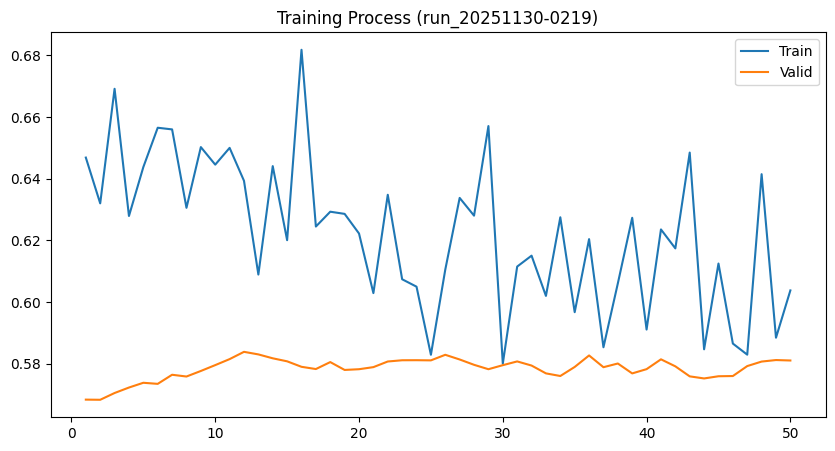

训练完成。


In [7]:
# 设置保存路径
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
timestamp = time.strftime("%Y%m%d-%H%M")
experiment_name = f"run_{timestamp}"
model_save_path = os.path.join(results_dir, f"{experiment_name}_model.pt")
loss_plot_path = os.path.join(results_dir, f"{experiment_name}_loss_curve.png")
metric_save_path = os.path.join(results_dir, f"{experiment_name}_metrics.csv")
test_save_path = os.path.join(results_dir, f"{experiment_name}_inference_results.csv")

print(f"🚀 开始训练: {experiment_name}")

if not CONFIG['inference_only']:
    # 3. 把 scheduler 传进去
    model = train_3D(CONFIG['n_epochs'], loaders, model, optimizer, criterion, 
                     CONFIG['train_on_gpu'], performance_metrics, model_save_path,metric_save_path, 0.5, 
                     scheduler=scheduler) # 传入 scheduler
    
    # 训练结束后处理数据
    if os.path.exists(metric_save_path):
        df = pd.read_csv(metric_save_path)
        
        # 直接在 Jupyter 中画图
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df['Training Loss'], label='Train')
        plt.plot(df['epoch'], df['Validation Loss'], label='Valid')
        plt.legend()
        plt.title(f'Training Process ({experiment_name})')
        
        plt.savefig(loss_plot_path)
        plt.show() # 保存后再显示        
        
        print("训练完成。")

In [8]:
print("\n--- 开始测试集评估 ---")
# 加载刚刚训练好的模型（或者你可以手动指定其他路径）
best_model_path = model_save_path
# best_model_path = 'results/run_20251129-1415_model.pt'

if os.path.exists(best_model_path):
    print(f"加载模型权重: {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    print(f"正在测试 {len(part['test'])} 个测试集病例...")
    df_test = get_inference_performance_metrics_3D(model, part['test'], Pancreas_3D_dataset, 
                                                  CONFIG['batch_size'], CONFIG['train_on_gpu'], 
                                                  0.5, kw, kh, kc, dw, dh, dc)
    print("\n📊 测试集结果统计:")
    display(df_test.describe()) # Jupyter 特有的漂亮表格显示
    
    df_test.to_csv(test_save_path, index=False)
    print(f"✅ 详细测试结果已保存至: {test_save_path}")
else:
    print("未找到模型文件。")


--- 开始测试集评估 ---
加载模型权重: results/run_20251130-0219_model.pt...
正在测试 17 个测试集病例...

📊 测试集结果统计:


,specificity,sensitivity,precision,F1_score,F2_score,DSC
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.996138,0.472800,0.374477,0.401051,0.436534,0.401051
std,0.001705,0.128359,0.109600,0.091405,0.102920,0.091406
min,0.993055,0.143448,0.233655,0.211437,0.164622,0.211435
25%,0.995059,0.426500,0.280646,0.330163,0.430633,0.330162
50%,0.996106,0.509930,0.390311,0.431981,0.462378,0.431980
75%,0.997117,0.540334,0.426672,0.470140,0.500748,0.470140
max,0.999386,0.625648,0.629543,0.528745,0.540029,0.528744


✅ 详细测试结果已保存至: results/run_20251130-0219_inference_results.csv


🚀 正在处理病人: Patient0027 ...
✅ 文件已保存到 results/
🎯 正在展示胰腺面积最大的层: [np.int64(55), np.int64(56), np.int64(57), np.int64(58)]


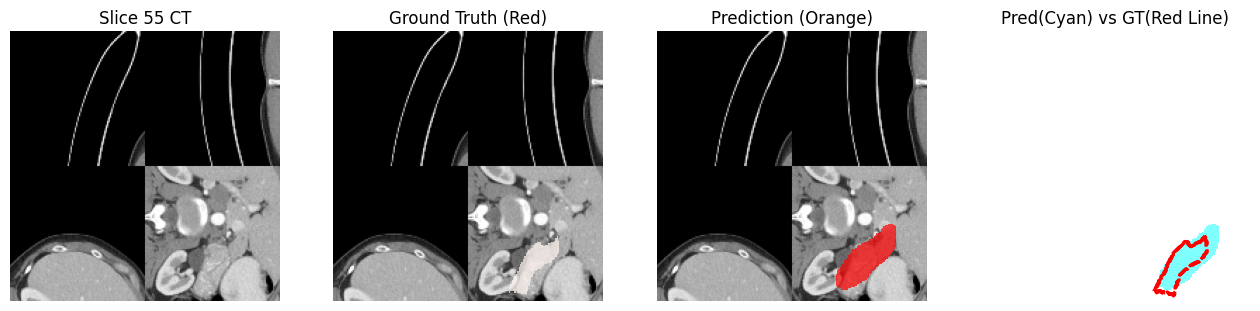

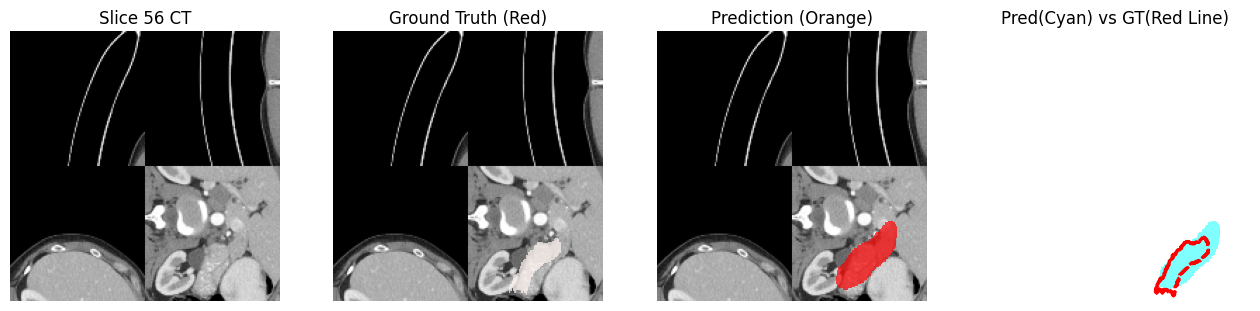

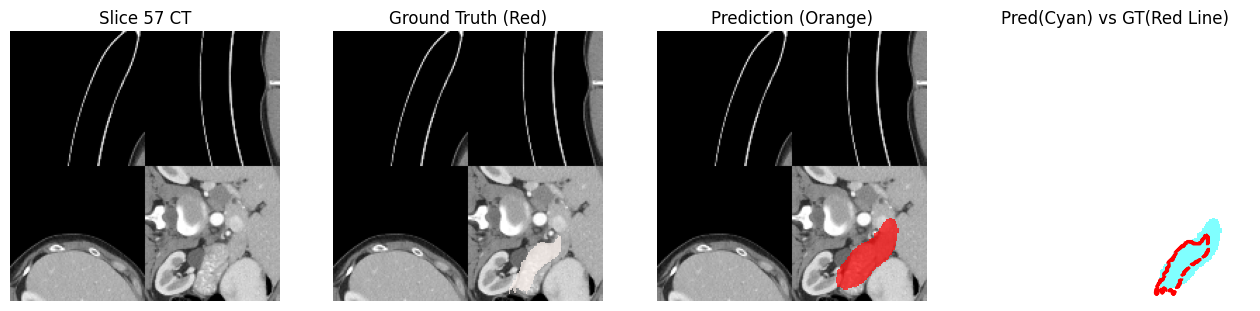

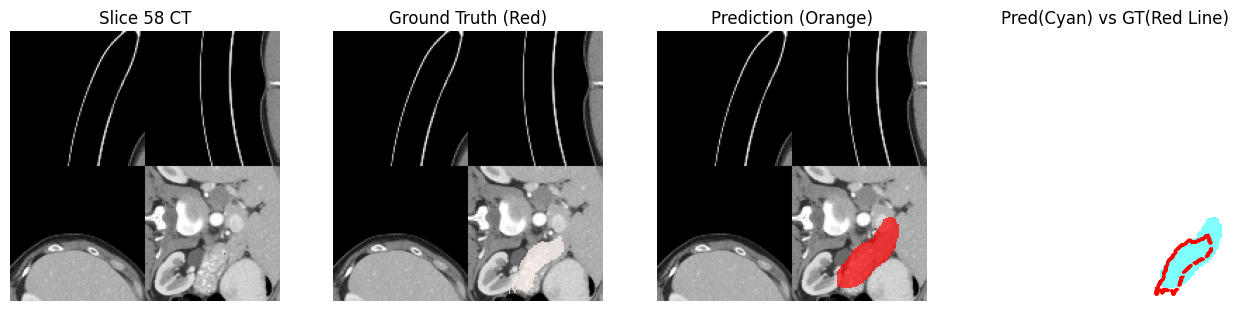

🚀 正在处理病人: Patient0056 ...
✅ 文件已保存到 results/
🎯 正在展示胰腺面积最大的层: [np.int64(65), np.int64(66), np.int64(67), np.int64(68)]


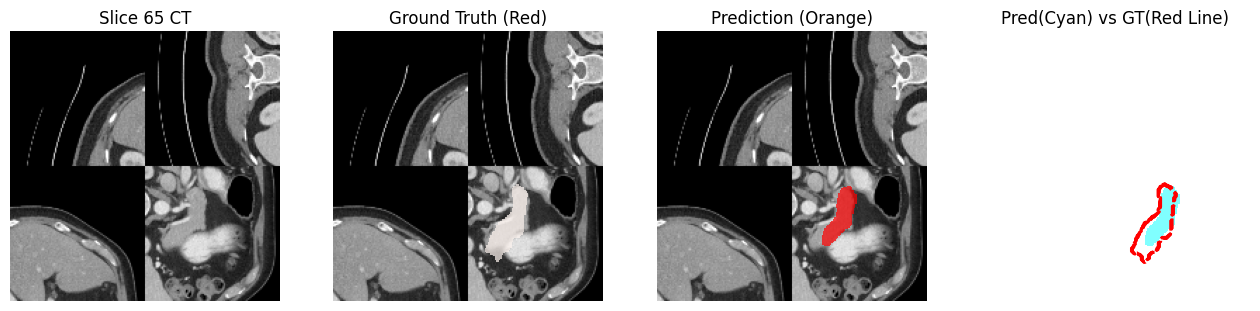

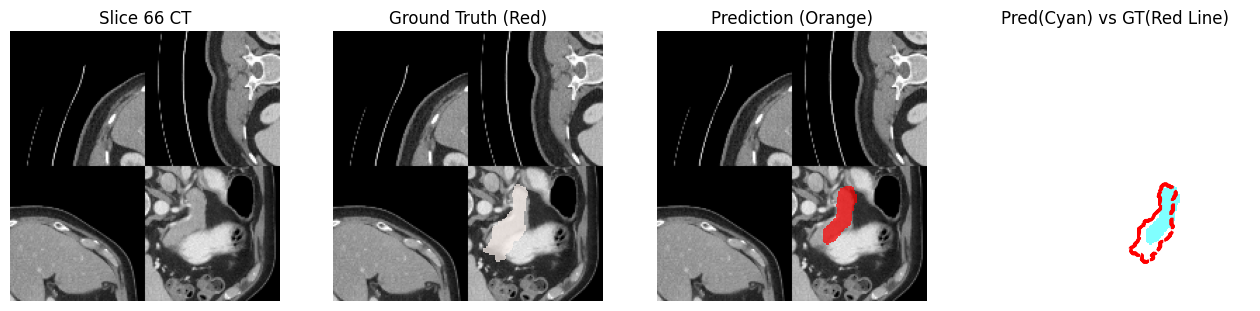

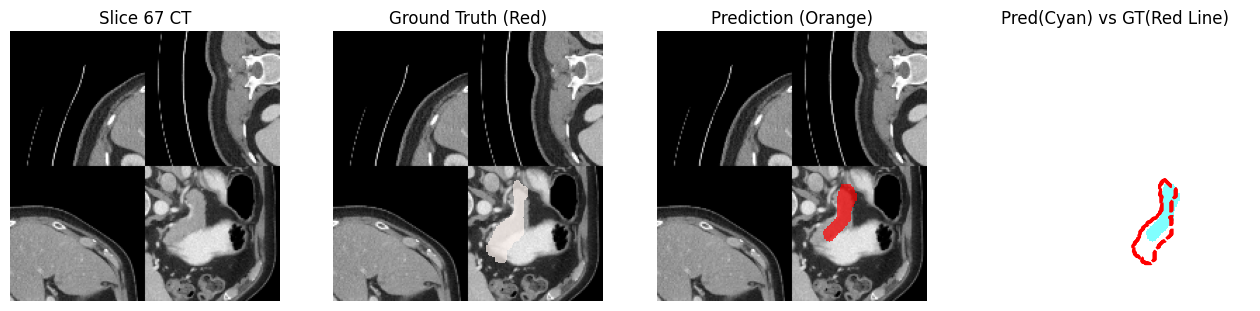

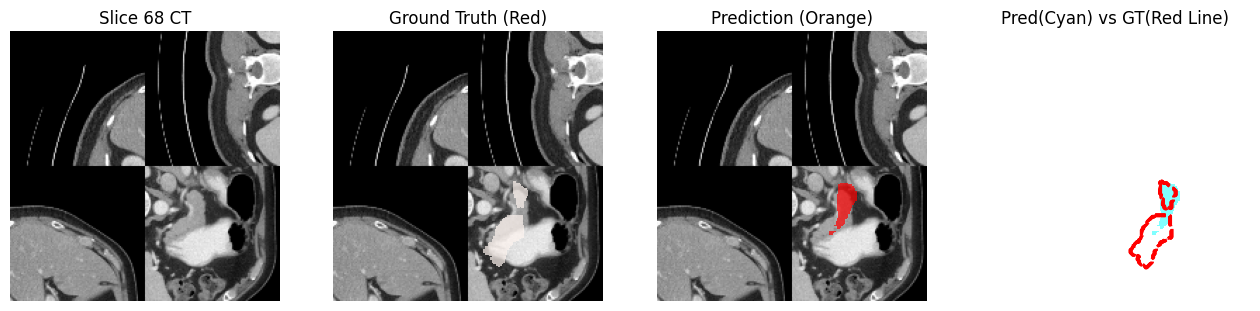

🚀 正在处理病人: Patient0045 ...
✅ 文件已保存到 results/
🎯 正在展示胰腺面积最大的层: [np.int64(56), np.int64(57), np.int64(58), np.int64(59)]


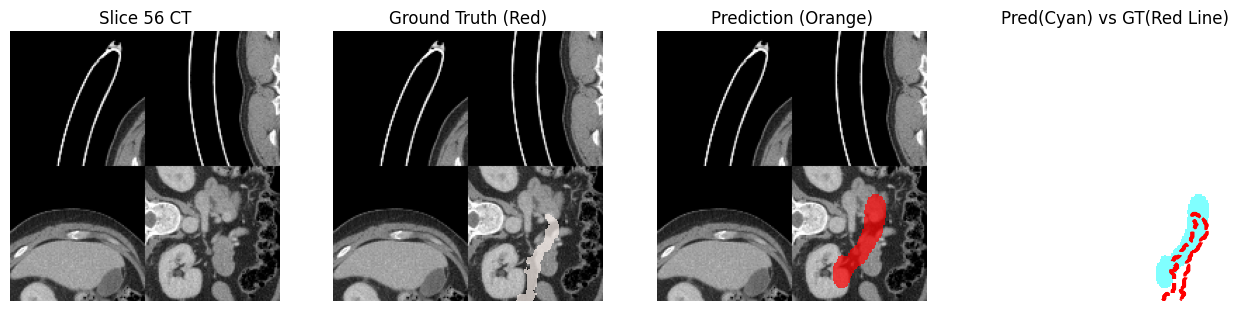

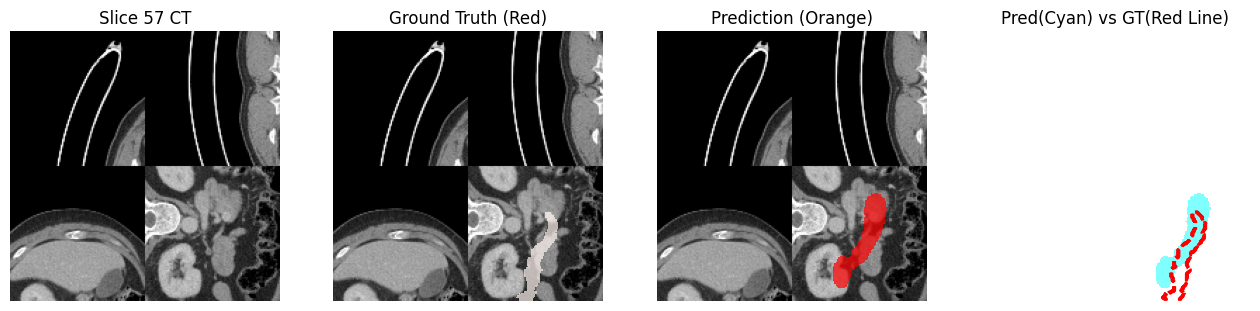

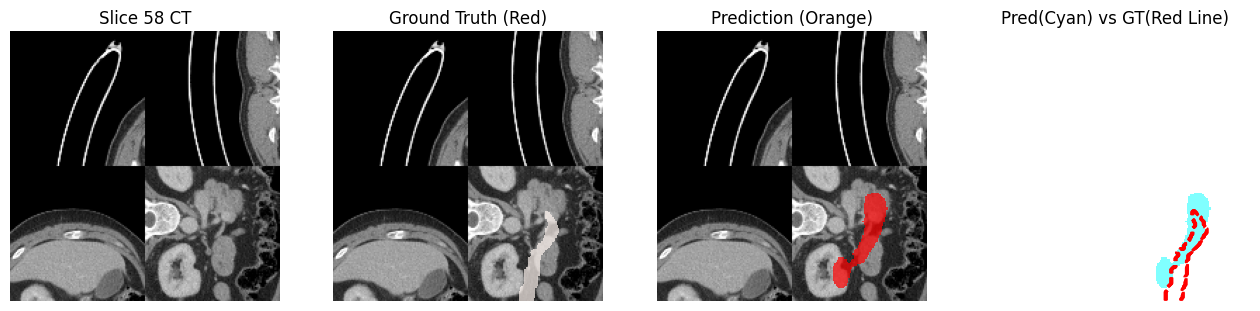

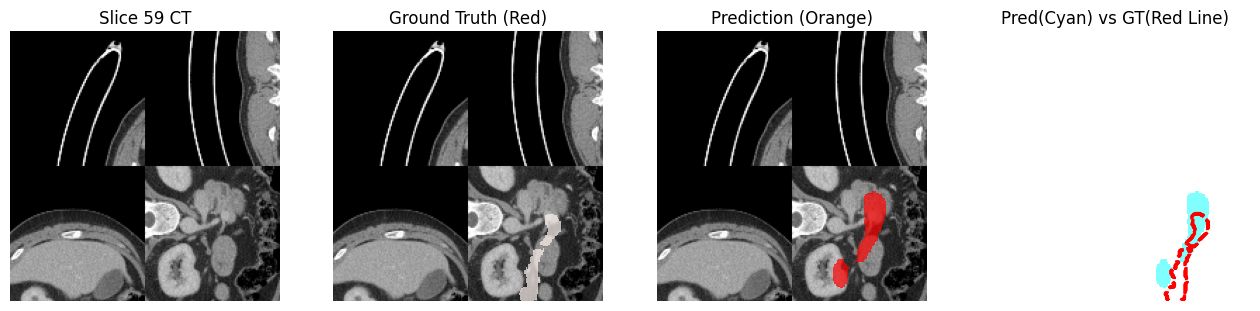

In [9]:
from inference import visualize_patient_prediction_3D

i=4
visualize_patient_prediction_3D(
    model=model, 
    patient=part['train'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['valid'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['test'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)

In [10]:
# 训练结束后自动关机
# !shutdown